In [8]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import graph_tool as gt
import igraph
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True

from autoCBH_funcs import mol2graph, graph2mol
from autoCBH import buildCBH
from sys import getsizeof

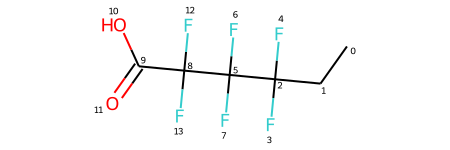

In [3]:
pfas = 'CCC(F)(F)C(F)(F)C(C(O)=O)(F)(F)'
m = Chem.MolFromSmiles(pfas)
m

In [4]:
cbh = buildCBH(pfas)

In [5]:
cbh.cbh_pdts

{0: {'F': 6, 'O': 2, 'C': 6},
 1: {'CF': 6, 'CC': 5, 'CO': 1, 'C=O': 1},
 2: {'CC(C)(F)F': 3, 'CC(=O)O': 1, 'CCC': 1},
 3: {'CC(F)(F)C(=O)O': 1, 'CC(F)(F)C(C)(F)F': 2, 'CCC(C)(F)F': 1},
 4: {'CC(F)(F)C(F)(F)C(=O)O': 1,
  'CC(F)(F)C(F)(F)C(C)(F)F': 1,
  'CCC(F)(F)C(C)(F)F': 1,
  'CC(C)(F)F': 6,
  'CC(=O)O': 2,
  'CCC': 1},
 5: {'CC(F)(F)C(=O)O': 1,
  'CCC(F)(F)C(F)(F)C(C)(F)F': 1,
  'CCC(C)(F)F': 1,
  'CC(F)(F)C(F)(F)C(F)(F)C(=O)O': 1}}

In [13]:
rcts = {}
pdts = {}
for cbh_level in range(len(cbh.cbh_pdts)):
    rcts[cbh_level] = {Chem.MolFromSmiles(mol) : num for mol, num in cbh.cbh_rcts[cbh_level].items()}
    pdts[cbh_level] = {Chem.MolFromSmiles(mol) : num for mol, num in cbh.cbh_pdts[cbh_level].items()}

360 360


In [29]:
from rdkit.Chem import rdChemReactions

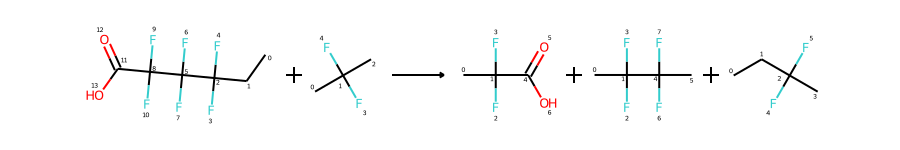

In [58]:
rct = ''
pdt = ''
cbh_level = 3
for key in cbh.cbh_pdts[cbh_level]:
    pdt = pdt + '.' + key
pdt = pdt[1:]
for key in cbh.cbh_rcts[cbh_level]:
    rct = rct + '.' + key
rct = rct[1:]
rxn = cbh.smile+'.'+rct+'>>'+pdt
rdChemReactions.ReactionFromSmarts(rxn, useSmiles=True)

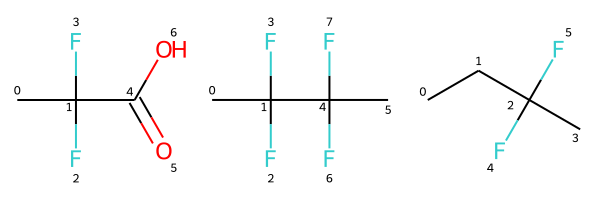

In [21]:
Draw.MolsToGridImage(pdts[3])

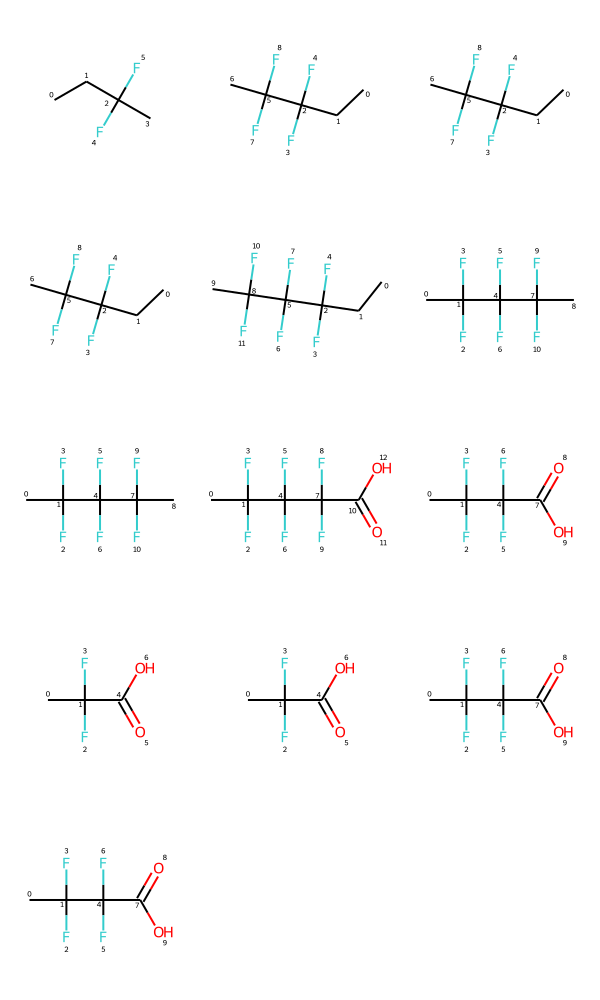

In [3]:
Draw.MolsToGridImage(cbh.bond_centric(2))

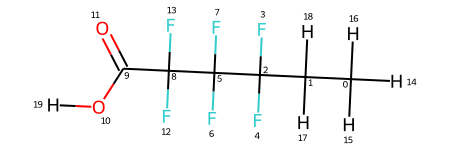

In [43]:
m = Chem.AddHs(m)
m

In [664]:
def mol2graph(mol):
    """Molecule to Graph
    Converts a RDkit.Chem Mol object into an undirected igraph object.
    Sourced directly from: https://iwatobipen.wordpress.com/2018/05/30/active-learning-rdkit-chemoinformatics-ml/
    
    ARGUMENTS
    ---------
    :mol: RDkit.Chem Mol object - represents molecule
    
    RETURN
    ------
    :g: igraph Graph object - chemical graph of molecule
        attributes include: atom idx, atom atomic numbers, atomic symbols, bond start/end atom idx's, bond types
    """
    # Gather atom/bond attributes
    # atom attributes: atom number, atomic number, atom symbol
    # bond attributes: atom 1 index, atom 2 index, atom bond type as number
    atom_attributes = [(a.GetIdx(), a.GetAtomicNum(), a.GetSymbol()) for a in mol.GetAtoms()]
    bond_attributes = [(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType(), b.GetBondTypeAsDouble()) 
                       for b in mol.GetBonds()]
    # generate chemical graph
    g = igraph.Graph()
    # Create vertices for each Atom
    for a_attr in atom_attributes:
        g.add_vertex(a_attr[0], AtomicNum=a_attr[1], AtomicSymbol=a_attr[2])
    # Create edges for each Bond
    for b_attr in bond_attributes:
        g.add_edge(b_attr[0], b_attr[1], BondType=b_attr[2], BondTypeDouble=b_attr[3])
    return g 

def graph2mol(graph): 
    """Graph to Molecule
    Converts undirected igraph object to RDkit.Chem Mol object.
    Sourced directly from: https://iwatobipen.wordpress.com/2018/05/30/active-learning-rdkit-chemoinformatics-ml/
    
    ARGUMENTS
    ---------
    :g: igraph Graph object - chemical graph of molecule
        attributes include: atom idx, atom atomic numbers, atomic symbols, bond start/end atom idx's, bond types
    
    RETURN
    ------
    :mol: RDkit.Chem Mol object - represents molecule
    """
    emol = Chem.rdchem.RWMol()
    # Add each vertex as an Atom
    for v in graph.vs():
        emol.AddAtom(Chem.Atom(v["AtomicNum"]))
    # Add each edge as a Bond
    for e in graph.es():
        emol.AddBond(e.source, e.target, e['BondType'])
    mol = emol.GetMol()
    # Generates SMILES str then converts back to Mol object 
    # (hack to ensure implicit hydrogens are accounted)
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return mol

In [28]:
g = mol2graph(m)
g_adj = np.array(g.get_adjacency().data)
g_dis = np.array(g.shortest_paths())

In [540]:
mf = AllChem.GetMorganFingerprintAsBitVect(m,3)
mf

In [668]:
# Bond Centric
# This is the shortest paths from the source. 
# CBH-1 = just the source of the edge (shortest_path with length of 1)
#      - do the same with path from target
# CBH-3 = (shortest_path arrays with length <= 2)
#      - do the same with path from target
sub_mols = []
for e in g.es():
    gsp_s, gsp_t = g.get_shortest_paths(e.source), g.get_shortest_paths(e.target)
    gsp_si, gsp_ti = np.where(np.array([len(x) for x in gsp_s])<=2)[0], np.where(np.array([len(x) for x in gsp_t])<=2)[0]
    temp, temp2 = (gsp_s[i] for i in gsp_si), (gsp_t[i] for i in gsp_ti)
    e_inds = list(set([x[-1] for x in temp] + [x[-1] for x in temp2]))
    sm = graph2mol(g.subgraph(e_inds))
    sub_mols.append(sm)
Draw.MolsToGridImage(sub_mols)

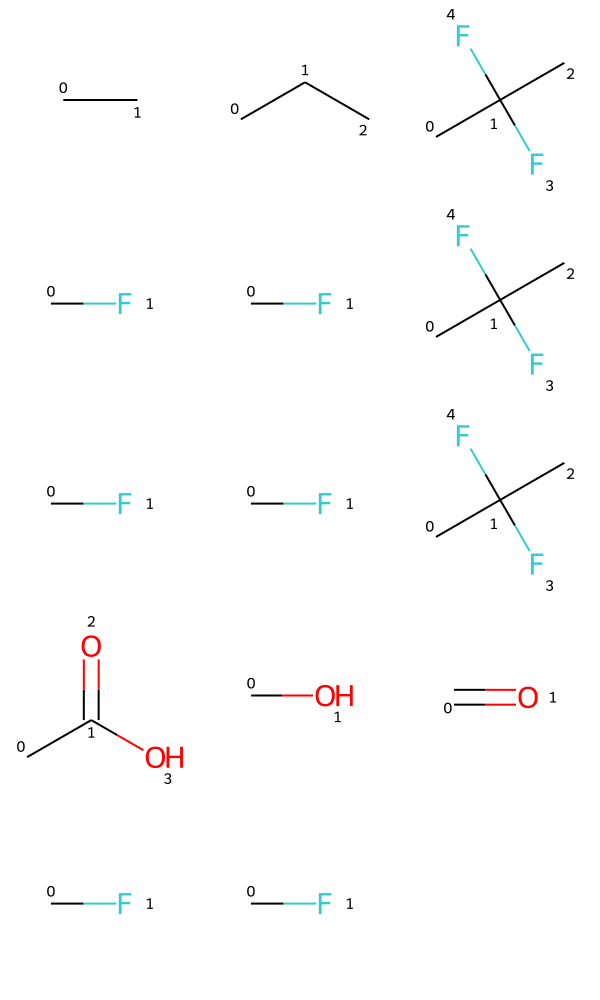

In [653]:
# Atom Centric
sub_mols = []
for ai in range(len(g_adj)):
    a_inds = np.where(g_dis[ai]<=1)[0]
    sm = graph2mol(g.subgraph(a_inds))
    sub_mols.append(sm)
Draw.MolsToGridImage(sub_mols)

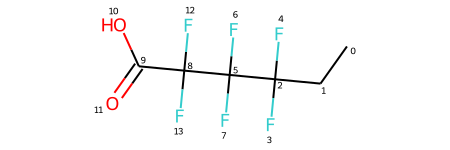

In [654]:
m

In [650]:
ls_idx = []
for a in m.GetAtoms():
    if a.GetDegree()>2:
        ls_idx.append(a.GetIdx())

In [655]:
ls_idx

[2, 5, 8, 9]

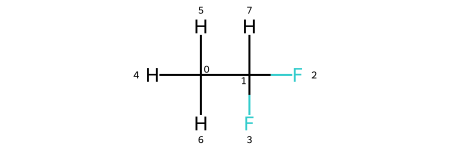

In [640]:
Chem.rdmolops.AddHs(sub_mols[0])

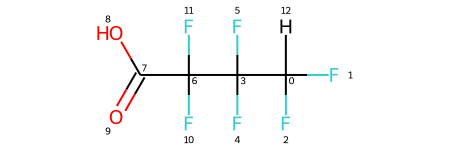

In [615]:
emol = Chem.rdchem.RWMol()
for v in g.vs():
    emol.AddAtom(Chem.Atom(v["AtomicNum"]))
for e in g.es():
    emol.AddBond(e.source, e.target, e['BondType'])
emol.AddAtom(Chem.Atom(1))
emol.AddBond(0,12,Chem.BondType.SINGLE)
mol = emol.GetMol()
mol

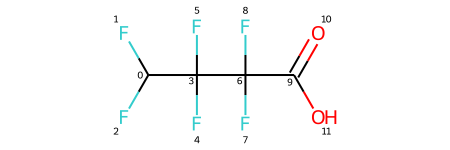

In [657]:
Chem.MolFromSmiles(Chem.MolToSmiles(mol))